<a href="https://colab.research.google.com/github/nabeelvalley/Docs/blob/master/Data%20Science%20with%20Python/%20image_classification_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> This file is intended for use in Google Colabs (or a GPU based environment) because it will pretty much die with CPU-only

# Image Processing with Keras

> The notes in here are based on [this YouTube series](https://www.youtube.com/watch?v=4Bh3gqHkIgc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=32) from Jeff Heaton, further information on CNN's however can also be found in [this series](https://www.youtube.com/watch?v=vT1JzLTH4G4) from Stanford

In [ ]:
# Set Colab TF to 2.x

try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

TensorFlow 2.x selected.
Note: using Google CoLab


## Overview

For processing images we'll use `PIL` which enables you to use images directly in Python

To install `PIL` use:

```bash
pip install pillow
```

We'll also use the `requests` package to get images from the internet via an HTTP request

In [ ]:
IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg'

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import requests

from io import BytesIO
from matplotlib.pyplot import imshow

from PIL import Image

We can import an image with:

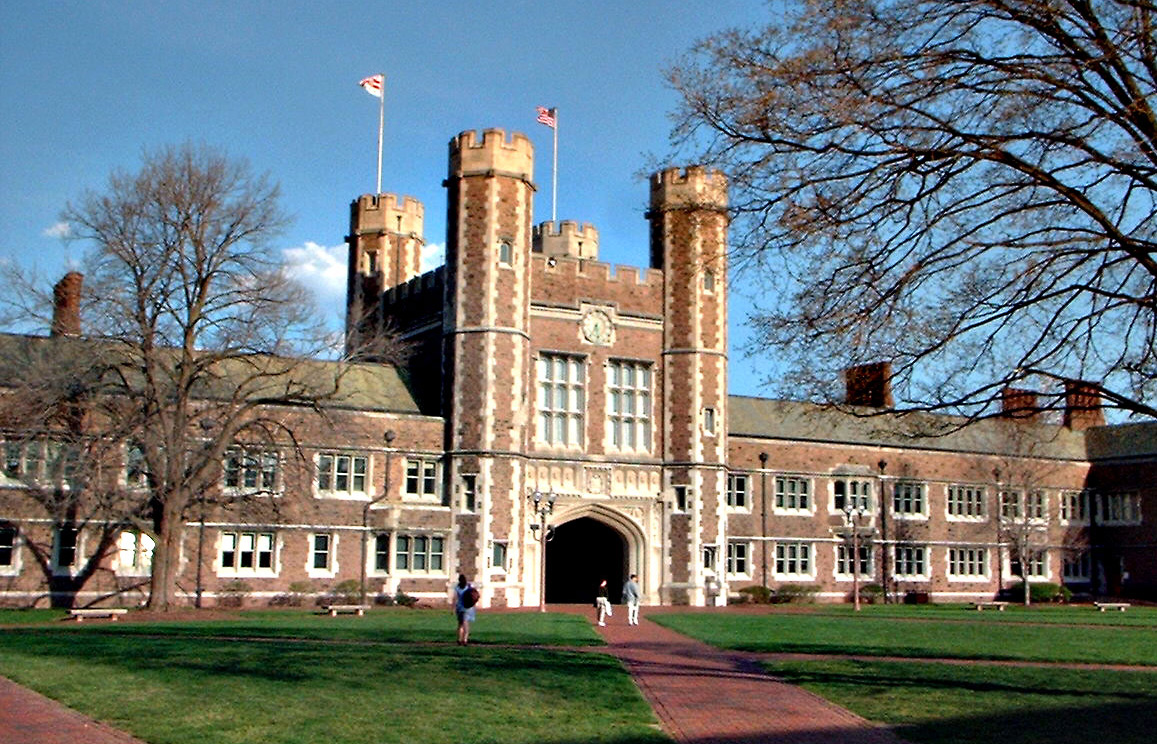

In [ ]:
response = requests.get(IMAGE_URL)

img = Image.open(BytesIO(response.content))
img.load()

img

Each image that we import has it's pixels in an array grouped by position as well as color list. So for an image that's 3x3 pixels, we have an array like so:

```py
[
  [[r, g, b], [r, g, b], [r, g, b]],
  [[r, g, b], [r, g, b], [r, g, b]],
  [[r, g, b], [r, g, b], [r, g, b]],
]
```

We can see our data set by converting the image to an array:

In [ ]:
np.array(img)

array([[[ 86, 133, 177],
        [ 85, 132, 176],
        [ 84, 133, 176],
        ...,
        [ 94, 128, 153],
        [ 91, 128, 155],
        [ 94, 129, 169]],

       [[ 86, 133, 177],
        [ 88, 135, 179],
        [ 88, 137, 180],
        ...,
        [ 96, 133, 159],
        [ 92, 136, 165],
        [ 99, 141, 183]],

       [[ 83, 130, 174],
        [ 87, 134, 178],
        [ 89, 138, 181],
        ...,
        [108, 150, 175],
        [100, 149, 179],
        [ 97, 144, 186]],

       ...,

       [[127,  77,  76],
        [131,  81,  80],
        [128,  80,  76],
        ...,
        [  4,  10,  10],
        [  2,  11,  10],
        [  2,  11,  10]],

       [[132,  81,  77],
        [129,  80,  75],
        [124,  75,  70],
        ...,
        [  4,  10,  10],
        [  3,  12,  11],
        [  3,  12,  11]],

       [[140,  90,  83],
        [137,  87,  80],
        [130,  81,  74],
        ...,
        [ 11,  17,  17],
        [ 10,  19,  18],
        [ 10,  19,  18]]

Using the `PIL` library we can also generate images from an array of data, for example a 64x64 pixel image can be created whith the following:

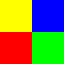

In [ ]:
w, h = 64,  64
data = np.zeros((h, w, 3), dtype=np.uint8)

def assign_pixels(rgb, row_start, col_start):
  for row in range(32):
    for col in range(32):
      data[row + row_start, col + col_start] = rgb

# yellow
assign_pixels([255, 255, 0], 0, 0)
# red
assign_pixels([255, 0, 0], 32, 0)
# blue
assign_pixels([0, 0, 255], 0, 32)
#green
assign_pixels([0, 255, 0], 32, 32)

img = Image.fromarray(data, 'RGB')

img

Using a combation of reading, writing, and processing using `PIL` and `numpy`. When using images some preprocessing tasks we may want to do are:

1. Size and Shape normalization
2. Greyscaling
3. Flatting of Image data to 1D array
4. Normalizing pixel values from `0 -> 255` to `-126 -> 126`

## Computer Vision

When processing computer vision we can make use of something like `Colabs` to ensure that we have a GPU to run on, otherwise these tasks can take a very long time, when setting up we'll use the `Python with GPU` configuration on Colab

When using image type data there are some distinctions to when we use NN's for other tasks:

- Usually classification
- Input is now 3 dimensional - heght, width, colour
- Data is not transformed, no Z-scores or Dummy Variables
- Processing is much slower
- Different Layer types such as Dense, Convolutional, and Max Pooling
- Data will be in the form of image files and not CSV (TF provides some mechanisms to support with this)

Some common ML DB's are the MNIST Digits and MNIST Fashion data which have the same data scructures as well as the CIFAR data which is used for ResNet training

### Convolutional Neural Networks

A Convolution Layer is a layer type that's able to scan across the previous layer, this allows it to identify features that are positioned relative to other features

In a Convolution Layer some of the things we need to specify are:

- Number of filters
- Filter size
- Stride
- Padding
- Activation Function

### Max Pooling

After a colvolution we may want to subsample the previous Convolution layer in order to either connect to an output based on a Dense layer or pass it into another Convolution Layer to identify even higher order features

Max pooling layers help us to decrease resolution

## MNIST Digit Dataset

### Importing Data

We can import the MNIST dataset from TF to use like so:

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow.keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Training: X {X_train.shape} Y {y_train.shape}")
print(f"Testing : X {X_test.shape} Y {y_test.shape}")

11493376/11490434 [==============================] - 0s 0us/step
Training: X (60000, 28, 28) Y (60000,)
Testing : X (10000, 28, 28) Y (10000,)


Based on the above we can see that we have a set of images with a size of 28x28. We can view the raw data for one of these with:

In [ ]:
pd.DataFrame(X_train[0])

0   1   2   3    4    5    6    7   ...   20   21   22   23  24  25  26  27
0    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
1    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
2    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
3    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
4    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
5    0   0   0   0    0    0    0    0  ...  166  255  247  127   0   0   0   0
6    0   0   0   0    0    0    0    0  ...  253  242  195   64   0   0   0   0
7    0   0   0   0    0    0    0   49  ...   82   56   39    0   0   0   0   0
8    0   0   0   0    0    0    0   18  ...    0    0    0    0   0   0   0   0
9    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
10   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
11   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
12   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
13   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
14   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
15   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
16   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
17   0   0   0   0    0    0    0    0  ...   64    0    0    0   0   0   0   0
18   0   0   0   0    0    0    0    0  ...    2    0    0    0   0   0   0   0
19   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
20   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
21   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
22   0   0   0   0    0    0   18  171  ...    0    0    0    0   0   0   0   0
23   0   0   0   0   55  172  226  253  ...    0    0    0    0   0   0   0   0
24   0   0   0   0  136  253  253  253  ...    0    0    0    0   0   0   0   0
25   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
26   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
27   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0

[28 rows x 28 columns]

Or as an image using `plt.imshow`:

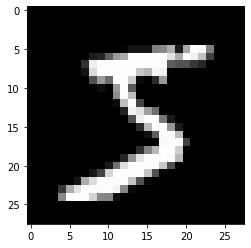

In [ ]:
plt.imshow(X_train[0], cmap='gray', interpolation='nearest')

### Training a Network

#### Preprocessing

Before training a network we'll do some preprocessing to format the data into somehting we can use directly by our network:

In [ ]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

In [ ]:
# the below may be necessary to reshape the data based on the Keras backend
# for example there could be different image format requirements for TF vs
# another library that Keras is compatible with

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the X
X_train_norm = X_train.astype('float32') / 255
X_test_norm = X_test.astype('float32') / 255

# categorize the y
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
input_shape

(28, 28, 1)

In [ ]:
X_train_norm.shape, X_test_norm.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
y_train_cat.shape, y_test_cat.shape

((60000, 10), (10000, 10))

#### Train Model

1. Define Sequential Model
2. Create a few Conv2D layers
3. Use a MaxPooling2D layer to reduce the resolution
4. Flatten the data to pass to a Dense Layer
5. Use a Dense Layer
6. Add some Dropout
7. Add the output Dense Layer

In [ ]:
model = Sequential()

model.add(Conv2D(
    64,                     # number of filters
    (3, 3),                 # kernal size     
    activation='relu',      # activation function
    input_shape=input_shape # input shape
))

model.add(Conv2D(
    64,
    (3, 3),
    activation='relu'
))

model.add(MaxPooling2D(
    pool_size=(2, 2)
))

model.add(Dropout(0.25))

model.add(Flatten())       # always need to flatten when moving from Conv Layer

model.add(Dense(
    num_classes, 
    activation='softmax'
))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                92170     
Total params: 129,738
Trainable params: 129,738
Non-trainable params: 0
__________________________________________________

Next, we can fit the model. Additionally we have some code to see how long the overall runtime will be for the training

In [ ]:
import time

print(f"Start: {time.ctime()}")

model.fit(
    X_train_norm, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_test_norm, y_test_cat)
)

print(f"End: {time.ctime()}")

Start: Sun Mar 22 15:28:46 2020
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 - 14s - loss: 0.2013 - accuracy: 0.9408 - val_loss: 0.0561 - val_accuracy: 0.9831
Epoch 2/12
60000/60000 - 8s - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.0469 - val_accuracy: 0.9849
Epoch 3/12
60000/60000 - 8s - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0423 - val_accuracy: 0.9862
Epoch 4/12
60000/60000 - 8s - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0361 - val_accuracy: 0.9885
Epoch 5/12
60000/60000 - 8s - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.0373 - val_accuracy: 0.9874
Epoch 6/12
60000/60000 - 8s - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0344 - val_accuracy: 0.9882
Epoch 7/12
60000/60000 - 8s - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0340 - val_accuracy: 0.9889
Epoch 8/12
60000/60000 - 8s - loss: 0.0194 - accuracy: 0.9934 - val_loss: 0.0410 - val_accuracy: 0.9887
Epoch 9/12
60000/60000 - 8s - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0355 - va

#### Evaluate Accuracy

Next we'll evaluate the accuracy of the models using our normal method:

In [ ]:
score = model.evaluate(
    X_test_norm, 
    y_test_cat, 
    verbose=0
)

print(f"Loss    : {score[0]}")
print(f"Accuracy: {score[1]}")

Loss    : 0.03515712368493842
Accuracy: 0.9901999831199646


## MNIST Fashion Dataset

### Import Data

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(f"Training: X {X_train.shape} Y {y_train.shape}")
print(f"Testing : X {X_test.shape} Y {y_test.shape}")

4423680/4422102 [==============================] - 0s 0us/step
Training: X (60000, 28, 28) Y (60000,)
Testing : X (10000, 28, 28) Y (10000,)


The Fashion Dataset pretty much works as a drop-in for the Digits dataset, we can just copy all the data from the above as-is and we should be able to train the model

### View Data

In [ ]:
pd.DataFrame(X_train[0])

0    1    2    3    4    5    6   ...   21   22   23   24   25   26   27
0    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3    0    0    0    0    0    0    0  ...    0    0    0    0    1    1    0
4    0    0    0    0    0    0    0  ...    0    1    3    4    0    0    3
5    0    0    0    0    0    0    0  ...    0    0    0    0   12   10    0
6    0    0    0    0    0    0    0  ...  109   64   23   77  130   72   15
7    0    0    0    0    0    0    0  ...  121  122  146  141   88  172   66
8    0    0    0    0    0    0    0  ...  213  164  127  123  196  229    0
9    0    0    0    0    0    0    0  ...  222  224  221  223  245  173    0
10   0    0    0    0    0    0    0  ...  211  213  223  220  243  202    0
11   0    0    0    0    0    0    0  ...  218  224  212  226  197  209   52
12   0    0    0    0    0    0    0  ...  213  222  220  245  119  167   56
13   0    0    0    0    0    0    0  ...  223  234  217  217  209   92    0
14   0    0    1    4    6    7    2  ...  223  229  215  218  255   77    0
15   0    3    0    0    0    0    0  ...  223  219  215  224  244  159    0
16   0    0    0    0   18   44   82  ...  188  250  248  233  238  215    0
17   0   57  187  208  224  221  224  ...  234  221  211  220  232  246    0
18   3  202  228  224  221  211  211  ...  210  204  209  222  228  225    0
19  98  233  198  210  222  229  229  ...  215  217  223  223  224  229   29
20  75  204  212  204  193  205  211  ...  212  209  222  220  221  230   67
21  48  203  183  194  213  197  185  ...  181  177  172  181  205  206  115
22   0  122  219  193  179  171  183  ...  192  176  156  167  177  210   92
23   0    0   74  189  212  191  175  ...  188  188  194  192  216  170    0
24   2    0    0    0   66  200  222  ...  176  166  168   99   58    0    0
25   0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
26   0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
27   0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[28 rows x 28 columns]

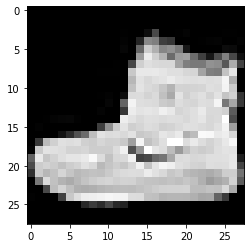

In [ ]:
plt.imshow(X_train[0], cmap='gray', interpolation='nearest')

### Preprocess Data

In [ ]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

In [ ]:
# the below may be necessary to reshape the data based on the Keras backend
# for example there could be different image format requirements for TF vs
# another library that Keras is compatible with

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the X
X_train_norm = X_train.astype('float32') / 255
X_test_norm = X_test.astype('float32') / 255

# categorize the y
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
input_shape

(28, 28, 1)

In [ ]:
X_train_norm.shape, X_test_norm.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
y_train_cat.shape, y_test_cat.shape

((60000, 10), (10000, 10))

### Define Model

In [ ]:
model = Sequential()

model.add(Conv2D(
    64,                     # number of filters
    (3, 3),                 # kernal size     
    activation='relu',      # activation function
    input_shape=input_shape # input shape
))

model.add(Conv2D(
    64,
    (3, 3),
    activation='relu'
))

model.add(MaxPooling2D(
    pool_size=(2, 2)
))

model.add(Dropout(0.25))

model.add(Flatten())       # always need to flatten when moving from Conv Layer

model.add(Dense(
    num_classes, 
    activation='softmax'
))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                92170     
Total params: 129,738
Trainable params: 129,738
Non-trainable params: 0
________________________________________________

### Train Model

In [ ]:
import time

print(f"Start: {time.ctime()}")

model.fit(
    X_train_norm, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_test_norm, y_test_cat)
)

print(f"End: {time.ctime()}")

Start: Sun Mar 22 15:30:32 2020
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 - 9s - loss: 0.4766 - accuracy: 0.8304 - val_loss: 0.3773 - val_accuracy: 0.8646
Epoch 2/12
60000/60000 - 8s - loss: 0.3117 - accuracy: 0.8907 - val_loss: 0.3111 - val_accuracy: 0.8879
Epoch 3/12
60000/60000 - 8s - loss: 0.2711 - accuracy: 0.9044 - val_loss: 0.2719 - val_accuracy: 0.9026
Epoch 4/12
60000/60000 - 8s - loss: 0.2426 - accuracy: 0.9133 - val_loss: 0.2580 - val_accuracy: 0.9098
Epoch 5/12
60000/60000 - 8s - loss: 0.2197 - accuracy: 0.9201 - val_loss: 0.2515 - val_accuracy: 0.9089
Epoch 6/12
60000/60000 - 8s - loss: 0.2031 - accuracy: 0.9262 - val_loss: 0.2401 - val_accuracy: 0.9152
Epoch 7/12
60000/60000 - 8s - loss: 0.1898 - accuracy: 0.9316 - val_loss: 0.2320 - val_accuracy: 0.9170
Epoch 8/12
60000/60000 - 8s - loss: 0.1785 - accuracy: 0.9348 - val_loss: 0.2334 - val_accuracy: 0.9182
Epoch 9/12
60000/60000 - 8s - loss: 0.1670 - accuracy: 0.9391 - val_loss: 0.2293 - val

### Evaluate Model

In [ ]:
score = model.evaluate(
    X_test_norm, 
    y_test_cat, 
    verbose=0
)

print(f"Loss    : {score[0]}")
print(f"Accuracy: {score[1]}")

Loss    : 0.22508650785684586
Accuracy: 0.9229000210762024


## ResNets in Keras

A Risidual Layer, also known as a skip layer, allows us to add some previous output as an additional input to another layer. This enables our network to go deeper than they would under normal circumstances while still showing a potential improvement in the output

We can look at implementing a ResNet using the CIFAR Dataset


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

from six.moves import cPickle 

import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

### Import the Data

In [ ]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((50000, 32, 32, 3), (10000, 32, 32, 3)), ((50000, 1), (10000, 1)))

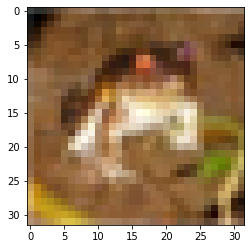

In [ ]:
plt.imshow(X_train[0], cmap='gray', interpolation='nearest')

### Constants for Training

In [ ]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = X_train.shape[3]

# Subtracting pixel mean improves accuracy
# This centers the pixel values around 0
SUBTRACT_PIXEL_MEAN = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif version == 2:
    DEPTH = COLORS * 9 + 2

### Defining the ResNet Functions

The different ResNet functions based on the two papers can be seen defined below. They both make use of the common `resnet_layer` function definition

The papers are:

1. ResNet v1: K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.
2. ResNet v2: He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). Identity mappings in deep residual networks. In European conference on computer vision (pp. 630-645). Springer, Cham.

The difference between the two is that V2 makes use of batch normalization before each weight layer

#### ResNet Layer Definition

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

#### ResNet v1

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

#### ResNet v2

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Normalize Data

In [ ]:
# Input image dimensions
input_shape = X_train.shape[1:]

# Normalize data
X_train_norm = X_train.astype('float32') / 255
X_test_norm = X_test.astype('float32') / 255

if SUBTRACT_PIXEL_MEAN:
    X_train_mean = np.mean(X_train, axis=0)
    X_train_norm -= X_train_mean
    X_test_norm -= X_train_mean

# Categorize target
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

### Define Model Based on Version

In [ ]:
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=lr_schedule(0)),
    metrics=['accuracy']
)

model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

### Train Model

In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    min_lr=0.5e-6
)

callbacks = [lr_reducer, lr_scheduler]

In the below section we have a choice to use image augmentation which will apply random transformations like resizing and moving around the image so the model does not overfit, it's not really doing anything more complicated than that

In [ ]:
import time

print(f"Start: {time.ctime()}")

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(
        X_train_norm, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test_norm, y_test_cat),
        shuffle=True,
        callbacks=callbacks
    )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train_norm)

    model.fit_generator(
        datagen.flow(
          X_train_norm,
          y_train_cat, 
          batch_size=BATCH_SIZE
        ),
        validation_data=(X_test_norm, y_test_cat),
        epochs=EPOCHS, 
        verbose=0, 
        workers=1,
        callbacks=callbacks, 
        use_multiprocessing=False
    )


print(f"End: {time.ctime()}")

Start: Sun Mar 22 15:32:22 2020
Using real-time data augmentation.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.

### Evaluate the Model

In [ ]:
scores = model.evaluate(X_test_norm, y_test_cat, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Using your Own Images with Keras

When we're using common datasets, e.g. from Keras, we have certain convenience methods for accessing and working with the data, like we see below

In [6]:
from tensorflow.keras.datasets import cifar10
import numpy as np

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]


We can see some `32x32` images with a colour depth of `3` (0 - 255)

Usually when using any image training we try to resize/structure our images in a standard size so that we can handle the data consistently

Sometimes we would want to change our RGB values to be between 0 and 1 or -1 and 1 during some preprocessing step

## Transforming Images

We can make use of the `make_square` function below to convert an image to a square. the version below will simply crop off a part of the image in whatever direction the image is longer

In [27]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
IMAGE_CHANNELS = 3

In [28]:
images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/"\
    "WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]

In [29]:
"""
Trim an image's edges in the longer direction to convert it to a square
"""
def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img

Next we will download all the images, convert them to a square, and resize to be our set `IMAGE_HEIGHT` and `IMAGE_WIDTH`

In [30]:
training_data = []

for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)
    training_data.append(np.asarray(img))

Once we've resized the images we will have a list of arrays, what we do next is transform the list into an array of arrays using the `np.array` function. The training data is then divided by `127.5` and subtracted by 1 to normalize between -1 and 1 

In [31]:
training_data = np.array(training_data) / 127.5 - 1.

In [32]:
training_data.shape

(7, 200, 200, 3)

In [33]:
training_data[0]

array([[[-0.12156863,  0.2627451 ,  0.59215686],
        [-0.12156863,  0.2627451 ,  0.59215686],
        [-0.10588235,  0.27058824,  0.59215686],
        ...,
        [-0.3254902 , -0.05098039,  0.27058824],
        [-0.61568627, -0.33333333,  0.01960784],
        [-0.40392157, -0.11372549,  0.20784314]],

       [[-0.16862745,  0.23921569,  0.59215686],
        [-0.14509804,  0.2627451 ,  0.61568627],
        [-0.11372549,  0.27058824,  0.59215686],
        ...,
        [-0.41176471, -0.25490196, -0.01960784],
        [-0.4745098 , -0.31764706, -0.02745098],
        [-0.81176471, -0.70196078, -0.42745098]],

       [[-0.15294118,  0.24705882,  0.60784314],
        [-0.1372549 ,  0.2627451 ,  0.62352941],
        [-0.10588235,  0.27058824,  0.6       ],
        ...,
        [-0.35686275, -0.15294118,  0.06666667],
        [-0.60784314, -0.37254902, -0.09803922],
        [-0.05882353,  0.18431373,  0.42745098]],

       ...,

       [[-0.00392157, -0.39607843, -0.43529412],
        [-0

It can also be useful to save the data object for future use. For high dimensional data CSVs don't work, and for large datasets `pickle` can be problematic. `numpy` has a way to save binary data to disk with the `np.save` method:

In [19]:
print("Saving training image binary...")
np.save("training",training_data) # Saves as "training_data.npy"
print("Done.")

Saving training image binary...
Done.


# DarkNet and YOLO

> YOLO = You Only Look Once

YOLO allows us to recognize multiple objects within the same CNN and is trained using a CNN which outputs a bunch of different layers and with bounding boxes and labels. The CNN makes multiple different sections/predictions but only looks at the input data one

DarkNet is the original implementation of YOLO for C, DarkFlow is the version that can be used from Python

## Installing DarkFlow

Because we are using Google CoLabs we need to first mount a folder to our Google Drive:


In [34]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


Next, install the dependency via pip

In [36]:
import sys

!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-w3slnstj
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-w3slnstj
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp36-none-any.whl size=8852 sha256=45f24d4bb6037ad7e561fa4252a74a9110be04812c6a38d81e8325c7631a9a99
  Stored in directory: /tmp/pip-ephem-wheel-cache-3u7xk07g/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


## Import the Weights

Since we aren't trying to retrain the YOLO model we can just import the preconfigured weights from the following giles:

In [39]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/Colab Notebooks'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/convert.py')

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/data/coco.names')

filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/625 [=========================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


Once we have downloaded the weights we need to transform them into a version that can be used by tensorflow:

In [40]:
import sys
!{sys.executable} "{filename_convert_script}" --weights "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-06-27 11:45:43.342763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-27 11:45:45.965322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-27 11:45:46.029800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-27 11:45:46.030601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-06-27 11:45:46.030658: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-27 11:45:46.282496: I tensorflow/stream_executor/platform/defa

## Delete the Conversion Script

Sicne we no longer need to conversion script this can be deleted:

In [41]:
import os
os.remove(filename_convert_script)

## Running DarkFlow

> Prereqs: `cython` and `opencv`

To use the DarkFlow library we need to do the following:

1. Import all needed packages
2. Define the YOLO configuration using Keras `flags`
3. Scan for available devices to selectively use GPU

### Import Packages

In [42]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

### Set Keras Flags

In [43]:
# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

['/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py']

### Scan for Device with GPU

In [44]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Making Predictions

To make a prediction we can do the following:

1. Create an instance of `YoloV3`
2. Load the weights and classes
3. Get an image to predict
4. Preprocess image
5. Make a Prediction
6. Preview the Output over the Image

### Create Yolo Instance

In [49]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

FLAGS.yolo_score_threshold = 0.5

### Load Weights

In [50]:
yolo.load_weights(FLAGS.weights).expect_partial()
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]

### Download Image

In [68]:
url = "https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/cook.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

### Preprocess Image

In [69]:
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

### Make Prediction

In [70]:
boxes, scores, classes, nums = yolo(img)

In [71]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	person, 0.9995919466018677, [0.31659657 0.10725167 0.68426734 0.74258983]
	dog, 0.9896982312202454, [0.51111    0.557695   0.9339741  0.81879824]
	microwave, 0.9839580059051514, [0.00695175 0.08101549 0.2790975  0.2882001 ]
	oven, 0.9383127093315125, [0.00773551 0.32521233 0.42321444 0.83368266]
	bottle, 0.8538914322853088, [0.73093545 0.23399046 0.76463544 0.32874534]
	bottle, 0.5538200736045837, [0.790116   0.26327905 0.8189085  0.3274593 ]


### Overlay Predictions

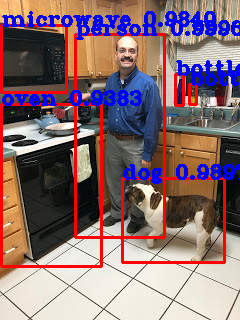

In [72]:
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

# Generative Adversarial Networks (GANs)

GANs are pairs of neural networks in which:

- Generator - One network generates data, starts working with random seed data
- Discriminator - Another tries to guess whether or not the data is real, this is trained on real data

The Generator tries to create data that fools the Discriminator

In general it is easier to train the Generator than the Discriminator

We have to sort of train the two independent of each other and not modify it one after the other. We should not train them together as this will lead to each _just_ trying to fool the other and not actually give us anything usable

We pass random seeds into the generator and it outputs images. These images are passed to the Discriminator during new rounds of traning as the fake images. When training the Discriminator we will pass in images from the traning set (real) and images from the generator (fake) and the role of the discriminator will be to correctly and confidently differentiate between the real and fake images

The ideal training case is where our generator creates images that are so realistic that our discriminator can no longer figure out what's real or fake

Overall, the distributions in the way the generator learns the data will begin to resemble the trends in the actual data over time

## Implementing a Simple GAN with Keras

### Import Packages


In [103]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

### Init Constants

Some constants that we're using to train the GAN are `GENERATE_RES` which is the resolution factor, and `DATA_PATH` which is where the files are stored

In [104]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/Colab Notebooks'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

### Download the Files

Download the files [from Kaggle]() and save it to the `data_path/face_images` directory

### Import the Downloaded Files

In [105]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [107]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  
  faces_path = os.path.join(DATA_PATH, 'face_images')

  if not os.path.exists(faces_path):
    os.mkdir()

  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

  0%|          | 0/20 [00:00<?, ?it/s]

Looking for file: /content/drive/My Drive/Colab Notebooks/training_data_96_96.npy
Loading training images...


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]

Saving training image binary...
Image preprocess time: 0:00:11.54


In [108]:
training_data

array([[[[-0.19999999,  0.23921573, -0.5294118 ],
         [-0.20784312,  0.22352946, -0.5294118 ],
         [-0.21568626,  0.21568632, -0.52156866],
         ...,
         [-0.10588235,  0.23921573, -0.5058824 ],
         [-0.09019607,  0.2313726 , -0.5058824 ],
         [-0.09803921,  0.2313726 , -0.5058824 ]],

        [[-0.20784312,  0.21568632, -0.5372549 ],
         [-0.20784312,  0.21568632, -0.5294118 ],
         [-0.19999999,  0.22352946, -0.5137255 ],
         ...,
         [-0.11372548,  0.2313726 , -0.5137255 ],
         [-0.12941176,  0.19215691, -0.54509807],
         [-0.12941176,  0.19215691, -0.54509807]],

        [[-0.2235294 ,  0.20000005, -0.5529412 ],
         [-0.20784312,  0.21568632, -0.5294118 ],
         [-0.19215685,  0.22352946, -0.5137255 ],
         ...,
         [-0.12941176,  0.21568632, -0.5294118 ],
         [-0.10588235,  0.21568632, -0.52156866],
         [-0.10588235,  0.21568632, -0.52156866]],

        ...,

        [[-0.3333333 , -0.00392157, -0

In [109]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Define a function to Build the Generator and Discriminator

In [110]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [111]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

> Also define a function for saving the images that are generated

In [112]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

### Generate a Test Image using the Noise

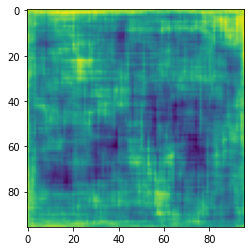

In [113]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [114]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49988297]], shape=(1, 1), dtype=float32)


In [115]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Define Optimizers for the two networks 

In [116]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

### Define a Train Step

> Based on the [GAN in the Keras Documentation](https://www.tensorflow.org/tutorials/generative/dcgan)

The Train step uses `GradientTape` to enable the networks to train at the same time but separately. This allows us to apply the weight updates on our own so that we can handle it manually instead of having TF apply it automatically to the network

In [117]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

### Define the Tranining Process

In [118]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

### Train the Model

In [126]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6930996179580688,disc loss=1.0064759254455566, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.6931149959564209,disc loss=1.0064730644226074, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=0.6930887699127197,disc loss=1.0064938068389893, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=0.6931302547454834,disc loss=1.0064555406570435, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=0.6930830478668213,disc loss=1.0065312385559082, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=0.6931189298629761,disc loss=1.0064769983291626, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=0.6931207180023193,disc loss=1.0064527988433838, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=0.693107545375824,disc loss=1.0064951181411743, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=0.6931174993515015,disc loss=1.006460428237915, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=0.6931171417236328,disc loss=1.0064548254013062, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=0.69312983751297,disc loss=1.006

In [121]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))